## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

(720, 1280, 3)


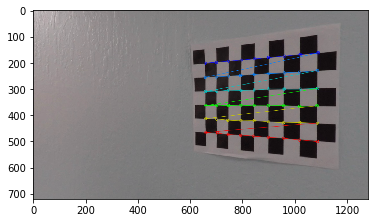

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #plt.imshow(img)
        #cv2.waitKey(500)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undst = cv2.undistort(img, mtx, dist, None, mtx)
print(undst.shape)
plt.imshow(undst)
#cv2.destroyAllWindows()

True

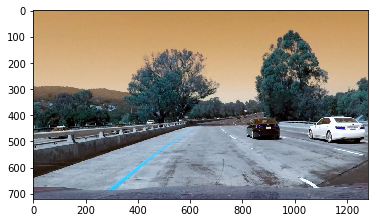

In [2]:
i='../test_images/test1.jpg'
img= cv2.imread(i)
undst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)
cv2.imwrite('undst.jpg',undst)

# Line Class

In [3]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        #self.diffs = np.array([0,0,0], dtype='float')
        self.diffs = [np.array([0,0,0], dtype='float')]
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

#  Edge detection Pipeline

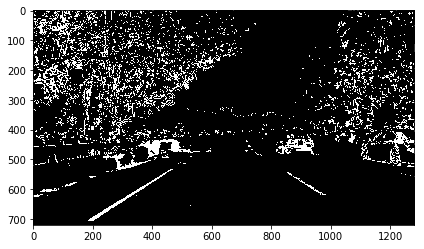

In [4]:



def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
	"""
	Takes an image, gradient orientation, and threshold min/max values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Apply x or y gradient with Sobel function
	# and take the absolute value
	if orient == 'x':
		abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
	if orient == 'y':
		abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
	# Rescale back to 8 bit integer
	scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
	# Create a copy and apply the threshold
	binary_output = np.zeros_like(scaled_sobel)
	binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

	return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
	"""
	Return the magnitude of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Take both Sobel x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Calculate the gradient magnitude
	grad_mag = np.sqrt(sobelx**2 + sobely**2)
	# Rescale to 8 bit
	scale_factor = np.max(grad_mag)/255
	grad_mag = (grad_mag/scale_factor).astype(np.uint8)
	# Create a binary image of ones where threshold is met, zeros otherwise
	binary_output = np.zeros_like(grad_mag)
	binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1

	# Return the binary image
	return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
	"""
	Return the direction of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Calculate the x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Take the absolute value of the gradient direction,
	# apply a threshold, and create a binary image result
	abs_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
	binary_output =  np.zeros_like(abs_dir)
	binary_output[(abs_dir >= thresh[0]) & (abs_dir <= thresh[1])] = 1

	# Return the binary image
	return binary_output


def hls_thresh(img, thresh=(100, 255)):
	"""
	Convert RGB to HLS and threshold to binary image using S channel
	"""
	hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
	s_channel = hls[:,:,2]
	binary_output = np.zeros_like(s_channel)
	binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
	return binary_output


def combined_thresh(img):
	abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
	mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
	dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
	hls_bin = hls_thresh(img, thresh=(170, 255))

	combined = np.zeros_like(dir_bin)
	combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

	return combined  # DEBUG


img_file = '../test_images/straight_lines1.jpg'
img_file = '../test_images/test5.jpg'



img = mpimg.imread(img_file)
img = cv2.undistort(img, mtx, dist, None, mtx)

combined= combined_thresh(img)


plt.imshow(combined, cmap='gray', vmin=0, vmax=1)
cv2.imwrite('binary.png',combined)
plt.tight_layout()
plt.show()

# Finding Lane pixels

In [5]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzerox)
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        

        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
       
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    print(nonzerox[left_lane_inds])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty= find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


    return  left_fitx , right_fitx,left_fit , right_fit,ploty



# Function to fit polynomial of 2nd degree

# Search From Prior

In [6]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit , right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    

    
    return left_fitx,right_fitx,ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#result,left_fitx,right_fitx ,ploty= search_around_poly(warped2,left_fit , right_fit)


# Image pipeline

In [10]:
def pipeline_lane(image,l_line,r_line):
    
    
    undst = cv2.undistort(image, mtx, dist, None, mtx) # undistort the current frame
    
    warped = cv2.warpPerspective(undst,M,(undst.shape[1],undst.shape[0]),flags=cv2.INTER_NEAREST) #perstective tranformation for the bird eye view
    
    result = combined_thresh(warped)  #identiy edges in the image using the combined threshold technique

    global frame # global frame variable to record the frame count
    global left_fit, right_fit
    global slow,fast

    #print(frame)
    
    if (l_line.detected == True and r_line.detected == True and frame > 20 ):
        left_fitx,right_fitx ,ploty= search_around_poly(result,left_fit , right_fit)
        fast = fast +1
    else:
        left_fitx , right_fitx,left_fit , right_fit,ploty= fit_polynomial(result)
        slow = slow +1
            

        
        

    
    #else:
    #leftx, lefty, rightx, righty= find_lane_pixels(result) # find out the lane pixels 
    

    #left_fitx, right_fitx, ploty = fit_poly(result.shape, leftx, lefty, rightx, righty) #fit a ploynomial for the given x,y pixels
    
    #left_fitx,right_fitx,ploty = search_around_poly(result,left_fitx , right_fitx) # find out the lane pixels 


    
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)  # polynomial in the real world scale
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)# polynomial in the real world scale
    
    #l_line.best_fit = np.vstack([l_line.best_fit,left_fit_cr])
    #r_line.best_fit = np.vstack([r_line.best_fit,right_fit_cr])
    
    #l_lane.best_fit = np.average(left_lane.best_fit[-5:], axis = 0)




    
    y_eval = np.max(ploty)*ym_per_pix  # y variable for pixel y=720 
    y0 = 0  # y variable for pixel y=0
    y1 = y_eval/2   # y variable for pixel 360
    
    # Calculate the real world measurements for coresponding pixels values 
    # equations coresponds to 2nd degree poly
    
    a1=(left_fit_cr[0]*(y0*ym_per_pix)**2 + left_fit_cr[1]*y0*ym_per_pix + left_fit_cr[2])
    b1 =(right_fit_cr[0]*(y0*ym_per_pix)**2 + right_fit_cr[1]*(y0*ym_per_pix) + right_fit_cr[2])
    
    a2=(left_fit_cr[0]*(y1*ym_per_pix)**2 + left_fit_cr[1]*y1*ym_per_pix + left_fit_cr[2])
    b2 =(right_fit_cr[0]*(y1*ym_per_pix)**2 + right_fit_cr[1]*(y1*ym_per_pix) + right_fit_cr[2])

    a3=(left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2])
    b3 =(right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2])
    
    # calculate the lane width for different y values, used for sanity check later on 
    d1 = np.absolute(a1-b1) 
    d2 = np.absolute(a2-b2)
    d3 = np.absolute(a3-b3)
    
    d_mean = (d1 +d2 +d3 )/3.0  # mean of the 3 different lane widths
    
    # Calculate the slope of the left and right lane polynomial at different y values
    # slope equation coresponds to the 1st derivative of the 2nd degree ploy equation
    
    slope1_1 = 2*left_fit_cr[0]*(y1*ym_per_pix) + left_fit_cr[1]*ym_per_pix
    slope2_1 = 2*right_fit_cr[0]*(y1*ym_per_pix) + right_fit_cr[1]*ym_per_pix
    
    slope1_2 = 2*left_fit_cr[0]*(y0*ym_per_pix) + left_fit_cr[1]*ym_per_pix
    slope2_2 = 2*right_fit_cr[0]*(y0*ym_per_pix) + right_fit_cr[1]*ym_per_pix
    
    slope1_3 = 2*left_fit_cr[0]*(y_eval*ym_per_pix) + left_fit_cr[1]*ym_per_pix
    slope2_3 = 2*right_fit_cr[0]*(y_eval*ym_per_pix) + right_fit_cr[1]*ym_per_pix
   
    
    s_mean1 = (slope1_1 + slope1_2 + slope1_3)/3.0  # mean of the 3 different slope values at different y for the left poly
    s_mean2 = (slope2_1 + slope2_2 + slope2_3)/3.0  # mean of the 3 different slope values at different y for the right poly
    
    
    s_mean = abs(s_mean1 - s_mean2) # find the difference between the mean slopes of the 2 ploynomials
    
    ################# coefficent diff #############
    
    #print(left_fit_cr[0]-right_fit_cr[0])
    #print(left_fit_cr[1]-right_fit_cr[1])
    #print(left_fit_cr[2]-right_fit_cr[2])
    
    
    
    #print("s_mean:"+str(s_mean)) # debugging 
    #####################
    
    #parallel = False
 
    #l_line.detected = False   #flag for whether line detected is good enough
    #r_line.detected = False
    
    # we assume all the lines detected are Not good untill they pass the sanity test
    
    
    # sanity test :1) mean lane width(d_mean) should be within the given range
    # sanity test: 2) diffenence between the slopes of the 2  polynomials should be almost 0, since the 
    # polynomials are suppose to be parallel
    if( d_mean > 3.1 and d_mean < 4.2 and s_mean < 0.0099):   
        #parallel = True
        l_line.detected = True # flag for passing the test
        r_line.detected = True
    else:
        l_line.detected = False # flag for passing the test
        r_line.detected = False


    
    #the calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])  
    #print(np.absolute(left_curverad - right_curverad))
  
    #print("d_mean:  " +str(d_mean)) # debug
    
    #check if line has passed the sanity test
    if (l_line.detected == True and r_line.detected == True ):
        
        l_line.recent_xfitted.append(left_fitx) # append the good pixels to the left line class
        r_line.recent_xfitted.append(right_fitx) # append the good pixels to the right line class

        l_line.radius_of_curvature =left_curverad  # equate the radius of curvature in real world scale
        r_line.radius_of_curvature =right_curverad

        l_line.current_fit=left_fit_cr  # equate the polynomial coefficients
        r_line.current_fit=right_fit_cr
        #print(l_line.current_fit)
        
        
        a3=(l_line.current_fit[0]*(y_eval*ym_per_pix)**2 + l_line.current_fit[1]*y_eval*ym_per_pix + l_line.current_fit[2])
        b3 =(r_line.current_fit[0]*(y_eval*ym_per_pix)**2 + r_line.current_fit[1]*(y_eval*ym_per_pix) + r_line.current_fit[2])
        c = (a3+b3) /2  # lane offset calculation
        c = c*xm_per_pix  # lane offset in real world scale
        #global l_c
        #l_c.append(c)
        l_line.line_base_pos = c



        if frame >2:
            # pixel wise sucessive polynomial coefficients
            l_line.diffs.append(np.absolute(l_line.current_fit[-1] - l_line.current_fit[-2]))
            r_line.diffs.append(np.absolute(r_line.current_fit[-1] - r_line.current_fit[-2]))

        #l_line.allx = leftx # lane pixels
        #r_line.ally = rightx
    
    warp_zero = np.zeros_like(result).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #points for visualisation
    pts_left = np.array([np.transpose(np.vstack([(l_line.recent_xfitted)[-1], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_line.recent_xfitted[-1], ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result_final = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)

    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText1 = (10,100)
    bottomLeftCornerOfText2 = (900,100)
    bottomLeftCornerOfText3 = (600,100)
    bottomLeftCornerOfText4 = (10,640)



    fontScale              = 0.5
    fontColor              = (255,255,255)
    lineType               = 1

    cv2.putText(result_final,"Radius of curvature:"+str(l_line.radius_of_curvature)+"m", bottomLeftCornerOfText1, font, fontScale,fontColor,lineType)
    cv2.putText(result_final,"Lane Offset:"+str(l_line.line_base_pos)+"m", bottomLeftCornerOfText2, font, fontScale,fontColor,lineType)
    cv2.putText(result_final,"frame no:"+str(frame), bottomLeftCornerOfText4, font, fontScale,fontColor,lineType)
    frame = frame +1 # increment frame

    

    
    
    return result_final

# Perspective transform to Bird's eye view

In [11]:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
src1 = np.array([[585,460],[203,720],[1127,720],[695,460]],dtype=np.float32)
dst = np.array([[320,0],[320,720],[960,720],[960,0]],dtype=np.float32)

M = cv2.getPerspectiveTransform(src1,dst) 
Minv = cv2.getPerspectiveTransform(dst,src1) 


# Main body

In [12]:
global fast
global slow 
fast =0
slow =0
ym_per_pix = 30.0/720 # meters per pixel in y dimension
xm_per_pix = 3.7/640.0 # meters per pixel in x dimensio
frame=1 # frame number
if __name__ == '__main__':


    l_line = Line() # initialse line class instance
    r_line = Line()
    
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640.0 # meters per pixel in x dimensio
    white_output = '../final_video33.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip('../project_video.mp4')
    #frame= frame +1
    white_clip = clip1.fl_image(lambda image: pipeline_lane(image,l_line,r_line))
    #frame= frame +1
    %time white_clip.write_videofile(white_output, audio=False)
    #print(slow)
    #print(fast)

[358 359 360 ..., 279 283 284]
[MoviePy] >>>> Building video ../final_video33.mp4
[MoviePy] Writing video ../final_video33.mp4


  0%|          | 1/1261 [00:00<07:39,  2.74it/s]

[358 359 360 ..., 279 283 284]


  0%|          | 2/1261 [00:00<07:46,  2.70it/s]

[359 360 361 ..., 278 279 283]


  0%|          | 3/1261 [00:01<07:43,  2.71it/s]

[361 362 363 ..., 273 278 279]


  0%|          | 4/1261 [00:01<07:38,  2.74it/s]

[362 363 364 ..., 273 278 279]


  0%|          | 5/1261 [00:01<07:34,  2.76it/s]

[363 364 365 ..., 273 278 279]


  0%|          | 6/1261 [00:02<07:35,  2.76it/s]

[365 366 367 ..., 267 272 273]


  1%|          | 7/1261 [00:02<07:33,  2.76it/s]

[366 367 368 ..., 267 268 273]


  1%|          | 8/1261 [00:02<07:32,  2.77it/s]

[367 368 369 ..., 268 272 273]


  1%|          | 9/1261 [00:03<07:31,  2.77it/s]

[366 367 368 ..., 267 268 273]


  1%|          | 10/1261 [00:03<07:32,  2.76it/s]

[365 366 367 ..., 263 267 268]


  1%|          | 11/1261 [00:03<07:32,  2.76it/s]

[366 367 368 ..., 262 263 268]


  1%|          | 12/1261 [00:04<07:38,  2.73it/s]

[363 364 365 ..., 252 257 258]


  1%|          | 13/1261 [00:04<07:34,  2.75it/s]

[362 363 364 ..., 252 257 262]


  1%|          | 14/1261 [00:05<07:36,  2.73it/s]

[293 294 295 ..., 257 258 262]


  1%|          | 15/1261 [00:05<08:06,  2.56it/s]

[363 364 365 ..., 258 262 263]


  1%|▏         | 16/1261 [00:05<07:56,  2.61it/s]

[365 366 367 ..., 257 262 263]


  1%|▏         | 17/1261 [00:06<07:47,  2.66it/s]

[362 363 364 ..., 257 258 262]


  1%|▏         | 18/1261 [00:06<07:42,  2.69it/s]

[362 363 364 ..., 256 257 262]


  2%|▏         | 19/1261 [00:06<07:38,  2.71it/s]

[362 363 364 ..., 251 257 262]


  2%|▏         | 29/1261 [00:10<07:02,  2.91it/s]

[343 344 345 ..., 246 247 252]


  2%|▏         | 30/1261 [00:10<07:16,  2.82it/s]

[343 344 345 ..., 246 251 252]


 16%|█▌        | 200/1261 [01:21<07:32,  2.34it/s]

[337 338 339 ..., 226 230 231]


 16%|█▌        | 201/1261 [01:21<07:27,  2.37it/s]

[271 272 273 ..., 226 230 231]


 16%|█▌        | 202/1261 [01:22<07:35,  2.32it/s]

[335 336 337 ..., 226 230 231]


 16%|█▌        | 203/1261 [01:22<07:26,  2.37it/s]

[335 336 337 ..., 230 231 236]


 28%|██▊       | 359/1261 [02:28<06:18,  2.38it/s]

[350 351 352 ..., 362 367 368]


 32%|███▏      | 403/1261 [02:46<06:05,  2.34it/s]

[337 338 339 ..., 330 331 336]


 32%|███▏      | 405/1261 [02:47<06:08,  2.32it/s]

[336 337 338 ..., 330 331 336]


 32%|███▏      | 406/1261 [02:47<06:04,  2.35it/s]

[334 335 336 ..., 314 325 331]


 32%|███▏      | 408/1261 [02:48<06:13,  2.29it/s]

[333 334 335 ..., 313 314 325]


 32%|███▏      | 409/1261 [02:49<06:16,  2.26it/s]

[333 334 335 ..., 313 314 325]


 33%|███▎      | 410/1261 [02:49<06:07,  2.32it/s]

[333 334 335 ..., 319 320 325]


 34%|███▍      | 427/1261 [02:56<05:53,  2.36it/s]

[321 322 323 ..., 299 310 315]


 34%|███▍      | 432/1261 [02:58<05:46,  2.39it/s]

[318 319 320 ..., 278 279 304]


 34%|███▍      | 433/1261 [02:59<05:57,  2.32it/s]

[315 316 317 ..., 286 287 288]


 34%|███▍      | 434/1261 [02:59<05:53,  2.34it/s]

[315 316 317 ..., 291 292 293]


 34%|███▍      | 435/1261 [03:00<06:07,  2.25it/s]

[314 315 316 ..., 287 288 299]


 35%|███▍      | 436/1261 [03:00<05:59,  2.30it/s]

[314 315 316 ..., 303 304 305]


 38%|███▊      | 478/1261 [03:18<05:35,  2.33it/s]

[317 318 319 ..., 320 325 326]


 38%|███▊      | 479/1261 [03:18<05:47,  2.25it/s]

[318 319 320 ..., 309 320 325]


 38%|███▊      | 480/1261 [03:19<05:47,  2.25it/s]

[317 318 319 ..., 309 315 320]


 38%|███▊      | 481/1261 [03:19<05:56,  2.19it/s]

[317 318 319 ..., 312 313 314]


 38%|███▊      | 482/1261 [03:19<05:47,  2.24it/s]

[314 315 316 ..., 302 303 304]


 38%|███▊      | 483/1261 [03:20<05:52,  2.20it/s]

[313 314 315 ..., 303 304 310]


 38%|███▊      | 484/1261 [03:20<05:46,  2.24it/s]

[314 315 316 ..., 307 308 309]


 38%|███▊      | 485/1261 [03:21<05:55,  2.18it/s]

[313 314 315 ..., 308 309 315]


 39%|███▊      | 486/1261 [03:21<05:48,  2.23it/s]

[314 315 316 ..., 326 330 331]


 39%|███▊      | 487/1261 [03:22<05:53,  2.19it/s]

[314 315 316 ..., 331 335 336]


 39%|███▊      | 488/1261 [03:22<05:45,  2.24it/s]

[316 317 318 ..., 335 336 341]


 40%|███▉      | 501/1261 [03:28<05:27,  2.32it/s]

[311 312 313 ..., 304 310 315]


 40%|███▉      | 502/1261 [03:28<05:23,  2.34it/s]

[310 311 312 ..., 305 309 310]


 40%|███▉      | 503/1261 [03:29<05:30,  2.29it/s]

[313 314 315 ..., 315 320 321]


 40%|███▉      | 504/1261 [03:29<05:22,  2.35it/s]

[313 314 315 ..., 314 315 320]


 40%|████      | 505/1261 [03:29<05:29,  2.29it/s]

[313 314 315 ..., 304 310 315]


 40%|████      | 506/1261 [03:30<05:22,  2.34it/s]

[313 314 315 ..., 304 310 315]


 40%|████      | 507/1261 [03:30<05:27,  2.30it/s]

[312 313 314 ..., 304 310 315]


 40%|████      | 508/1261 [03:31<05:19,  2.36it/s]

[313 314 315 ..., 299 310 315]


 40%|████      | 509/1261 [03:31<05:26,  2.30it/s]

[310 311 312 ..., 299 304 310]


 40%|████      | 510/1261 [03:32<05:21,  2.33it/s]

[310 311 312 ..., 309 310 315]


 41%|████      | 511/1261 [03:32<05:29,  2.28it/s]

[309 310 311 ..., 310 314 315]


 41%|████      | 512/1261 [03:32<05:23,  2.31it/s]

[312 313 314 ..., 309 310 315]


 41%|████      | 513/1261 [03:33<05:31,  2.26it/s]

[314 315 316 ..., 315 320 321]


 41%|████      | 514/1261 [03:33<05:23,  2.31it/s]

[313 314 315 ..., 299 310 315]


 41%|████      | 515/1261 [03:34<05:28,  2.27it/s]

[313 314 315 ..., 289 310 315]


 41%|████      | 516/1261 [03:34<05:19,  2.33it/s]

[313 314 315 ..., 279 283 304]


 41%|████      | 517/1261 [03:35<05:24,  2.29it/s]

[312 313 314 ..., 278 273 278]


 41%|████      | 518/1261 [03:35<05:18,  2.33it/s]

[313 314 315 ..., 288 289 289]


 41%|████      | 519/1261 [03:36<05:23,  2.29it/s]

[313 314 315 ..., 288 288 289]


 41%|████      | 520/1261 [03:36<05:16,  2.34it/s]

[315 316 317 ..., 302 302 303]


 41%|████▏     | 521/1261 [03:36<05:23,  2.29it/s]

[314 315 316 ..., 289 315 320]


 41%|████▏     | 522/1261 [03:37<05:15,  2.34it/s]

[314 315 316 ..., 315 320 325]


 41%|████▏     | 523/1261 [03:37<05:23,  2.28it/s]

[314 315 316 ..., 326 330 331]


 42%|████▏     | 524/1261 [03:38<05:16,  2.33it/s]

[314 315 316 ..., 320 325 331]


 42%|████▏     | 525/1261 [03:38<05:21,  2.29it/s]

[316 317 318 ..., 299 304 305]


 42%|████▏     | 527/1261 [03:39<05:16,  2.32it/s]

[313 314 315 ..., 294 315 320]


 42%|████▏     | 528/1261 [03:39<05:10,  2.36it/s]

[311 312 313 ..., 277 278 278]


 42%|████▏     | 529/1261 [03:40<05:16,  2.31it/s]

[313 314 315 ..., 288 288 289]


 42%|████▏     | 530/1261 [03:40<05:11,  2.35it/s]

[317 318 319 ..., 304 310 331]


 43%|████▎     | 539/1261 [03:44<05:05,  2.37it/s]

[322 323 324 ..., 322 323 324]


 43%|████▎     | 540/1261 [03:44<05:00,  2.40it/s]

[322 323 324 ..., 325 326 327]


 43%|████▎     | 541/1261 [03:45<05:05,  2.36it/s]

[323 324 325 ..., 331 332 333]


 43%|████▎     | 542/1261 [03:45<05:45,  2.08it/s]

[323 324 325 ..., 333 334 335]


 43%|████▎     | 545/1261 [03:47<05:12,  2.29it/s]

[323 324 325 ..., 325 326 327]


 43%|████▎     | 546/1261 [03:47<05:12,  2.29it/s]

[324 325 342 ..., 341 342 343]


 43%|████▎     | 547/1261 [03:48<05:12,  2.28it/s]

[324 325 326 ..., 317 318 319]


 43%|████▎     | 548/1261 [03:48<05:15,  2.26it/s]

[324 325 326 ..., 317 318 319]


 44%|████▎     | 549/1261 [03:48<05:18,  2.23it/s]

[324 325 326 ..., 321 322 323]


 44%|████▎     | 550/1261 [03:49<05:10,  2.29it/s]

[319 320 321 ..., 303 304 305]


 44%|████▎     | 551/1261 [03:49<05:15,  2.25it/s]

[318 319 320 ..., 308 309 310]


 44%|████▍     | 552/1261 [03:50<05:07,  2.30it/s]

[316 317 318 ..., 299 300 301]


 44%|████▍     | 553/1261 [03:50<05:17,  2.23it/s]

[316 317 318 ..., 317 318 319]


 44%|████▍     | 554/1261 [03:51<05:09,  2.28it/s]

[322 323 324 ..., 313 314 315]


 44%|████▍     | 555/1261 [03:51<05:18,  2.22it/s]

[323 324 325 ..., 321 322 323]


 44%|████▍     | 556/1261 [03:52<05:09,  2.28it/s]

[323 324 325 ..., 320 321 322]


 44%|████▍     | 557/1261 [03:52<05:18,  2.21it/s]

[323 324 325 ..., 321 322 323]


 44%|████▍     | 558/1261 [03:52<05:10,  2.26it/s]

[322 323 324 ..., 329 330 331]


 44%|████▍     | 560/1261 [03:53<05:07,  2.28it/s]

[304 305 306 ..., 277 278 279]


 44%|████▍     | 561/1261 [03:54<05:12,  2.24it/s]

[298 299 300 ..., 254 255 256]


 45%|████▍     | 562/1261 [03:54<05:06,  2.28it/s]

[293 294 295 ..., 224 225 226]


 45%|████▍     | 563/1261 [03:55<05:13,  2.23it/s]

[298 299 300 ..., 278 279 280]


 45%|████▍     | 564/1261 [03:55<05:05,  2.28it/s]

[306 307 308 ..., 305 306 307]


 45%|████▍     | 565/1261 [03:56<05:11,  2.23it/s]

[311 312 313 ..., 324 325 326]


 45%|████▍     | 566/1261 [03:56<05:04,  2.28it/s]

[319 320 321 ..., 323 324 325]


 45%|████▍     | 567/1261 [03:56<05:09,  2.24it/s]

[322 323 324 ..., 329 330 331]


 45%|████▌     | 568/1261 [03:57<05:04,  2.28it/s]

[324 325 326 ..., 333 334 335]


 45%|████▌     | 569/1261 [03:57<05:12,  2.21it/s]

[323 324 325 ..., 324 325 326]


 45%|████▌     | 570/1261 [03:58<05:05,  2.26it/s]

[322 323 324 ..., 329 330 331]


 45%|████▌     | 571/1261 [03:58<05:12,  2.21it/s]

[313 314 318 ..., 314 315 316]


 45%|████▌     | 572/1261 [03:59<05:04,  2.26it/s]

[319 320 321 ..., 319 320 321]


 45%|████▌     | 573/1261 [03:59<05:10,  2.22it/s]

[318 319 320 ..., 321 322 323]


 46%|████▌     | 574/1261 [04:00<05:03,  2.26it/s]

[319 320 321 ..., 329 330 331]


 46%|████▌     | 575/1261 [04:00<05:08,  2.22it/s]

[322 323 324 ..., 324 325 326]


 46%|████▌     | 576/1261 [04:00<05:02,  2.26it/s]

[323 324 325 ..., 333 334 335]


 46%|████▌     | 577/1261 [04:01<05:06,  2.23it/s]

[324 325 326 ..., 323 324 325]


 46%|████▌     | 578/1261 [04:01<05:01,  2.26it/s]

[327 328 329 ..., 328 329 330]


 46%|████▌     | 582/1261 [04:03<04:52,  2.32it/s]

[324 325 326 ..., 333 334 335]


 46%|████▋     | 584/1261 [04:04<05:04,  2.22it/s]

[ 6  7  8 ...,  3  4 10]


 46%|████▋     | 585/1261 [04:04<04:57,  2.27it/s]

[24 25 26 ...,  8  9  9]


 46%|████▋     | 586/1261 [04:05<04:59,  2.25it/s]

[ 1  2  3 ..., 15  4  5]


 47%|████▋     | 587/1261 [04:05<05:00,  2.24it/s]

[324 325 326 ..., 329 330 331]


 47%|████▋     | 592/1261 [04:07<04:47,  2.33it/s]

[310 311 312 ..., 317 317 318]


 47%|████▋     | 593/1261 [04:08<04:52,  2.29it/s]

[317 318 319 ..., 320 321 322]


 47%|████▋     | 594/1261 [04:08<04:53,  2.27it/s]

[314 315 316 ..., 320 321 322]


 47%|████▋     | 595/1261 [04:09<04:55,  2.25it/s]

[314 315 316 ..., 318 319 320]


 47%|████▋     | 596/1261 [04:09<04:59,  2.22it/s]

[311 312 313 ..., 316 317 318]


 47%|████▋     | 597/1261 [04:10<05:02,  2.20it/s]

[309 310 311 ..., 314 315 316]


 47%|████▋     | 598/1261 [04:10<05:01,  2.20it/s]

[309 310 311 ..., 304 305 306]


 48%|████▊     | 599/1261 [04:11<05:03,  2.18it/s]

[306 307 308 ..., 301 302 303]


 48%|████▊     | 600/1261 [04:11<05:04,  2.17it/s]

[304 305 306 ..., 317 318 318]


 48%|████▊     | 601/1261 [04:12<05:01,  2.19it/s]

[300 301 302 ..., 309 310 315]


 48%|████▊     | 602/1261 [04:12<05:01,  2.19it/s]

[298 299 300 ..., 309 309 310]


 48%|████▊     | 603/1261 [04:12<04:58,  2.21it/s]

[296 297 298 ..., 268 272 273]


 48%|████▊     | 604/1261 [04:13<04:56,  2.22it/s]

[298 299 300 ..., 267 247 268]


 48%|████▊     | 605/1261 [04:13<05:08,  2.13it/s]

[299 300 301 ..., 257 258 289]


 48%|████▊     | 606/1261 [04:14<05:05,  2.15it/s]

[300 301 302 ..., 296 296 297]


 48%|████▊     | 607/1261 [04:14<05:02,  2.16it/s]

[303 304 305 ..., 346 347 357]


 48%|████▊     | 608/1261 [04:15<05:04,  2.15it/s]

[295 296 297 ..., 304 331 336]


 48%|████▊     | 609/1261 [04:15<04:54,  2.21it/s]

[293 294 295 ..., 338 339 339]


 48%|████▊     | 610/1261 [04:16<04:55,  2.21it/s]

[293 294 295 ..., 325 325 325]


 48%|████▊     | 611/1261 [04:16<04:55,  2.20it/s]

[293 294 295 ..., 320 315 320]


 49%|████▊     | 612/1261 [04:17<04:54,  2.21it/s]

[295 296 297 ..., 339 307 308]


 49%|████▊     | 613/1261 [04:17<05:01,  2.15it/s]

[290 291 292 ..., 310 336 341]


 49%|████▊     | 614/1261 [04:18<04:55,  2.19it/s]

[290 291 292 ..., 346 347 352]


 49%|████▉     | 615/1261 [04:18<04:59,  2.15it/s]

[290 291 292 ..., 346 347 352]


 49%|████▉     | 616/1261 [04:18<04:57,  2.17it/s]

[290 291 292 ..., 361 361 361]


 49%|████▉     | 617/1261 [04:19<04:53,  2.20it/s]

[290 291 292 ..., 383 378 383]


 49%|████▉     | 619/1261 [04:20<04:57,  2.16it/s]

[216 285 286 ..., 386 386 387]


 50%|████▉     | 629/1261 [04:24<04:32,  2.32it/s]

[311 312 313 ..., 473 509 510]


 50%|█████     | 632/1261 [04:25<04:31,  2.32it/s]

[293 294 295 ..., 425 430 431]


 50%|█████     | 633/1261 [04:26<04:31,  2.31it/s]

[293 294 295 ..., 383 383 383]


 50%|█████     | 634/1261 [04:26<04:35,  2.28it/s]

[297 298 299 ..., 398 399 399]


 50%|█████     | 635/1261 [04:27<04:29,  2.32it/s]

[304 305 306 ..., 431 467 468]


 66%|██████▌   | 835/1261 [05:51<02:56,  2.41it/s]

[351 352 353 ..., 394 420 425]


 66%|██████▋   | 836/1261 [05:51<03:01,  2.34it/s]

[349 350 351 ..., 388 389 415]


 66%|██████▋   | 837/1261 [05:52<02:58,  2.38it/s]

[347 348 349 ..., 383 384 404]


 66%|██████▋   | 838/1261 [05:52<03:02,  2.32it/s]

[344 345 346 ..., 377 378 383]


 67%|██████▋   | 839/1261 [05:52<03:00,  2.34it/s]

[341 342 343 ..., 377 378 378]


 67%|██████▋   | 840/1261 [05:53<03:03,  2.30it/s]

[339 340 341 ..., 389 415 420]


 67%|██████▋   | 841/1261 [05:53<02:59,  2.34it/s]

[338 339 340 ..., 397 398 415]


 67%|██████▋   | 842/1261 [05:54<03:02,  2.29it/s]

[334 335 336 ..., 387 388 404]


 67%|██████▋   | 843/1261 [05:54<02:58,  2.34it/s]

[331 332 333 ..., 362 367 368]


 67%|██████▋   | 844/1261 [05:55<03:01,  2.30it/s]

[328 329 330 ..., 375 376 377]


 67%|██████▋   | 845/1261 [05:55<02:58,  2.34it/s]

[326 327 328 ..., 381 382 383]


 67%|██████▋   | 846/1261 [05:55<03:01,  2.29it/s]

[326 327 328 ..., 367 367 368]


 67%|██████▋   | 847/1261 [05:56<02:56,  2.34it/s]

[323 324 325 ..., 368 373 404]


 67%|██████▋   | 848/1261 [05:56<03:00,  2.29it/s]

[321 322 323 ..., 373 399 404]


 67%|██████▋   | 849/1261 [05:57<02:55,  2.35it/s]

[319 320 321 ..., 383 399 404]


 67%|██████▋   | 850/1261 [05:57<02:57,  2.31it/s]

[318 319 320 ..., 367 368 373]


 67%|██████▋   | 851/1261 [05:58<02:54,  2.35it/s]

[318 319 320 ..., 372 373 378]


 68%|██████▊   | 852/1261 [05:58<02:58,  2.29it/s]

[317 318 319 ..., 393 409 410]


 68%|██████▊   | 853/1261 [05:58<02:53,  2.35it/s]

[317 318 319 ..., 396 397 398]


 68%|██████▊   | 854/1261 [05:59<02:56,  2.30it/s]

[318 319 320 ..., 378 373 378]


 68%|██████▊   | 855/1261 [05:59<02:52,  2.36it/s]

[317 318 319 ..., 386 387 388]


 68%|██████▊   | 856/1261 [06:00<02:55,  2.31it/s]

[318 319 320 ..., 391 392 393]


 68%|██████▊   | 857/1261 [06:00<02:52,  2.35it/s]

[318 319 320 ..., 391 392 393]


 68%|██████▊   | 858/1261 [06:01<02:54,  2.30it/s]

[317 318 319 ..., 386 387 382]


 68%|██████▊   | 859/1261 [06:01<02:50,  2.36it/s]

[318 319 320 ..., 383 384 420]


 68%|██████▊   | 860/1261 [06:02<02:54,  2.30it/s]

[318 319 320 ..., 410 415 420]


 68%|██████▊   | 861/1261 [06:02<02:50,  2.35it/s]

[319 320 321 ..., 403 404 415]


 68%|██████▊   | 862/1261 [06:02<02:52,  2.31it/s]

[320 321 322 ..., 404 409 410]


 68%|██████▊   | 863/1261 [06:03<02:48,  2.36it/s]

[321 322 323 ..., 398 409 410]


 69%|██████▊   | 864/1261 [06:03<02:52,  2.30it/s]

[321 322 323 ..., 388 409 410]


 69%|██████▊   | 865/1261 [06:04<02:47,  2.36it/s]

[319 320 321 ..., 382 383 394]


 69%|██████▊   | 866/1261 [06:04<02:50,  2.31it/s]

[321 322 323 ..., 381 382 383]


 69%|██████▉   | 867/1261 [06:04<02:46,  2.37it/s]

[257 263 264 ..., 370 371 372]


 69%|██████▉   | 868/1261 [06:05<02:49,  2.32it/s]

[319 320 321 ..., 375 376 377]


 69%|██████▉   | 869/1261 [06:05<02:46,  2.36it/s]

[321 322 323 ..., 382 383 404]


 69%|██████▉   | 870/1261 [06:06<02:50,  2.30it/s]

[320 321 322 ..., 383 394 399]


 69%|██████▉   | 871/1261 [06:06<02:46,  2.34it/s]

[320 321 322 ..., 399 404 405]


 69%|██████▉   | 872/1261 [06:07<02:49,  2.30it/s]

[317 318 319 ..., 393 394 399]


 69%|██████▉   | 873/1261 [06:07<02:45,  2.34it/s]

[317 318 319 ..., 388 389 394]


 69%|██████▉   | 874/1261 [06:08<02:46,  2.32it/s]

[316 317 318 ..., 372 388 389]


 69%|██████▉   | 875/1261 [06:08<02:43,  2.36it/s]

[316 317 318 ..., 370 371 372]


 69%|██████▉   | 876/1261 [06:08<02:44,  2.34it/s]

[319 320 321 ..., 377 399 404]


 70%|██████▉   | 877/1261 [06:09<02:45,  2.32it/s]

[319 320 321 ..., 376 377 383]


 70%|██████▉   | 878/1261 [06:09<02:42,  2.35it/s]

[319 320 321 ..., 376 377 383]


 70%|██████▉   | 879/1261 [06:10<02:44,  2.32it/s]

[321 322 323 ..., 381 382 383]


 70%|██████▉   | 880/1261 [06:10<02:40,  2.37it/s]

[320 321 322 ..., 370 370 371]


 70%|██████▉   | 881/1261 [06:10<02:43,  2.32it/s]

[319 320 321 ..., 391 392 393]


 70%|██████▉   | 882/1261 [06:11<02:40,  2.37it/s]

[316 317 318 ..., 383 399 404]


 70%|███████   | 883/1261 [06:11<02:43,  2.30it/s]

[315 316 317 ..., 404 409 410]


 70%|███████   | 884/1261 [06:12<02:46,  2.27it/s]

[316 317 318 ..., 409 410 415]


 70%|███████   | 885/1261 [06:12<02:46,  2.26it/s]

[316 317 318 ..., 392 393 404]


 70%|███████   | 886/1261 [06:13<02:41,  2.32it/s]

[321 322 323 ..., 388 389 394]


 70%|███████   | 887/1261 [06:13<02:44,  2.28it/s]

[321 322 323 ..., 388 389 415]


 70%|███████   | 888/1261 [06:14<02:40,  2.32it/s]

[321 322 323 ..., 412 413 414]


 70%|███████   | 889/1261 [06:14<02:42,  2.29it/s]

[322 323 324 ..., 412 413 414]


 71%|███████   | 890/1261 [06:14<02:39,  2.32it/s]

[321 322 323 ..., 403 404 415]


 71%|███████   | 891/1261 [06:15<02:41,  2.30it/s]

[321 322 323 ..., 402 403 404]


 71%|███████   | 892/1261 [06:15<02:36,  2.36it/s]

[321 322 323 ..., 391 392 393]


 71%|███████   | 893/1261 [06:16<02:38,  2.32it/s]

[321 322 323 ..., 409 410 415]


 71%|███████   | 894/1261 [06:16<02:35,  2.36it/s]

[321 322 323 ..., 410 415 420]


 71%|███████   | 895/1261 [06:17<02:37,  2.32it/s]

[324 325 326 ..., 419 420 425]


 71%|███████   | 896/1261 [06:17<02:35,  2.35it/s]

[328 329 330 ..., 409 420 425]


 71%|███████   | 897/1261 [06:17<02:38,  2.29it/s]

[331 332 333 ..., 408 409 420]


 71%|███████   | 898/1261 [06:18<02:35,  2.34it/s]

[333 334 335 ..., 409 420 425]


 71%|███████▏  | 899/1261 [06:18<02:39,  2.27it/s]

[333 334 335 ..., 415 420 425]


 71%|███████▏  | 900/1261 [06:19<02:36,  2.31it/s]

[334 335 336 ..., 414 420 425]


 71%|███████▏  | 901/1261 [06:19<02:38,  2.27it/s]

[336 337 338 ..., 412 413 414]


 72%|███████▏  | 902/1261 [06:20<02:34,  2.32it/s]

[335 336 337 ..., 383 388 389]


 72%|███████▏  | 903/1261 [06:20<02:36,  2.28it/s]

[336 337 338 ..., 402 403 404]


 72%|███████▏  | 904/1261 [06:20<02:32,  2.34it/s]

[335 336 337 ..., 378 373 378]


 72%|███████▏  | 905/1261 [06:21<02:34,  2.30it/s]

[335 336 337 ..., 391 392 393]


 72%|███████▏  | 906/1261 [06:21<02:31,  2.35it/s]

[335 336 337 ..., 404 409 410]


 72%|███████▏  | 907/1261 [06:22<02:34,  2.30it/s]

[334 335 336 ..., 388 394 399]


 72%|███████▏  | 908/1261 [06:22<02:31,  2.33it/s]

[334 335 336 ..., 392 393 404]


 72%|███████▏  | 909/1261 [06:23<02:34,  2.27it/s]

[334 335 336 ..., 387 388 404]


 72%|███████▏  | 910/1261 [06:23<02:30,  2.33it/s]

[334 335 336 ..., 414 415 420]


 72%|███████▏  | 911/1261 [06:24<02:35,  2.25it/s]

[334 335 336 ..., 414 415 420]


 72%|███████▏  | 912/1261 [06:24<02:31,  2.30it/s]

[332 333 334 ..., 409 410 415]


 72%|███████▏  | 913/1261 [06:24<02:33,  2.27it/s]

[332 333 334 ..., 404 415 420]


 72%|███████▏  | 914/1261 [06:25<02:35,  2.24it/s]

[333 334 335 ..., 396 397 398]


 73%|███████▎  | 915/1261 [06:25<02:30,  2.30it/s]

[333 334 335 ..., 368 372 373]


 73%|███████▎  | 916/1261 [06:26<02:30,  2.30it/s]

[332 333 334 ..., 378 373 378]


 73%|███████▎  | 917/1261 [06:26<02:25,  2.36it/s]

[330 331 332 ..., 367 368 373]


 73%|███████▎  | 918/1261 [06:27<02:27,  2.33it/s]

[329 330 331 ..., 414 415 420]


 73%|███████▎  | 919/1261 [06:27<02:23,  2.39it/s]

[328 329 330 ..., 409 410 415]


 73%|███████▎  | 920/1261 [06:27<02:24,  2.37it/s]

[327 328 329 ..., 419 420 425]


 73%|███████▎  | 921/1261 [06:28<02:25,  2.33it/s]

[327 328 329 ..., 407 408 409]


 73%|███████▎  | 922/1261 [06:28<02:22,  2.39it/s]

[324 325 326 ..., 414 420 425]


 73%|███████▎  | 923/1261 [06:29<02:23,  2.35it/s]

[323 324 325 ..., 389 394 420]


 73%|███████▎  | 924/1261 [06:29<02:20,  2.40it/s]

[322 323 324 ..., 403 404 425]


 73%|███████▎  | 925/1261 [06:29<02:23,  2.33it/s]

[323 324 325 ..., 389 394 399]


 73%|███████▎  | 926/1261 [06:30<02:21,  2.37it/s]

[260 265 266 ..., 398 399 399]


 74%|███████▎  | 929/1261 [06:31<02:21,  2.35it/s]

[321 322 323 ..., 389 394 425]


 74%|███████▍  | 930/1261 [06:32<02:19,  2.37it/s]

[321 322 323 ..., 394 420 425]


 74%|███████▍  | 931/1261 [06:32<02:21,  2.33it/s]

[321 322 323 ..., 426 430 431]


 74%|███████▍  | 932/1261 [06:32<02:18,  2.37it/s]

[321 322 323 ..., 413 414 425]


 74%|███████▍  | 933/1261 [06:33<02:20,  2.33it/s]

[323 324 325 ..., 425 430 431]


 74%|███████▍  | 934/1261 [06:33<02:19,  2.35it/s]

[324 325 326 ..., 414 430 431]


 74%|███████▍  | 935/1261 [06:34<02:20,  2.32it/s]

[327 328 329 ..., 430 431 436]


 74%|███████▍  | 936/1261 [06:34<02:16,  2.38it/s]

[329 330 331 ..., 404 409 410]


 74%|███████▍  | 937/1261 [06:35<02:20,  2.31it/s]

[330 331 332 ..., 413 408 413]


 74%|███████▍  | 938/1261 [06:35<02:16,  2.36it/s]

[266 267 268 ..., 458 457 458]


 74%|███████▍  | 939/1261 [06:35<02:19,  2.31it/s]

[333 334 335 ..., 418 418 419]


 75%|███████▍  | 940/1261 [06:36<02:16,  2.35it/s]

[333 334 335 ..., 409 409 410]


 75%|███████▍  | 941/1261 [06:36<02:18,  2.30it/s]

[333 334 335 ..., 441 446 447]


 75%|███████▍  | 942/1261 [06:37<02:15,  2.35it/s]

[332 333 334 ..., 441 446 447]


 75%|███████▍  | 943/1261 [06:37<02:19,  2.28it/s]

[333 334 335 ..., 441 446 447]


 75%|███████▍  | 944/1261 [06:38<02:24,  2.19it/s]

[332 333 334 ..., 404 409 410]


 75%|███████▍  | 945/1261 [06:38<02:20,  2.25it/s]

[333 334 335 ..., 441 446 447]


 75%|███████▌  | 946/1261 [06:39<02:21,  2.23it/s]

[334 335 336 ..., 424 425 441]


 75%|███████▌  | 947/1261 [06:39<02:17,  2.29it/s]

[332 333 334 ..., 404 430 431]


 75%|███████▌  | 948/1261 [06:39<02:17,  2.27it/s]

[333 334 335 ..., 410 446 447]


 75%|███████▌  | 949/1261 [06:40<02:12,  2.35it/s]

[333 334 335 ..., 404 404 404]


 75%|███████▌  | 950/1261 [06:40<02:15,  2.29it/s]

[332 333 334 ..., 429 430 436]


 75%|███████▌  | 951/1261 [06:41<02:11,  2.36it/s]

[329 330 331 ..., 424 425 441]


 75%|███████▌  | 952/1261 [06:41<02:13,  2.32it/s]

[326 327 328 ..., 412 413 414]


 76%|███████▌  | 953/1261 [06:42<02:10,  2.36it/s]

[327 328 329 ..., 436 441 442]


 76%|███████▌  | 954/1261 [06:42<02:13,  2.30it/s]

[326 327 328 ..., 418 419 425]


 76%|███████▌  | 955/1261 [06:42<02:10,  2.34it/s]

[326 327 328 ..., 409 410 441]


 76%|███████▌  | 956/1261 [06:43<02:13,  2.29it/s]

[329 330 331 ..., 410 414 415]


 76%|███████▌  | 957/1261 [06:43<02:10,  2.33it/s]

[329 330 331 ..., 409 410 415]


 76%|███████▌  | 958/1261 [06:44<02:11,  2.30it/s]

[334 335 336 ..., 425 456 457]


 76%|███████▌  | 959/1261 [06:44<02:08,  2.35it/s]

[334 335 336 ..., 447 451 452]


 76%|███████▌  | 960/1261 [06:45<02:11,  2.28it/s]

[337 338 339 ..., 430 431 436]


 76%|███████▌  | 961/1261 [06:45<02:07,  2.35it/s]

[340 341 342 ..., 431 467 468]


 76%|███████▋  | 962/1261 [06:45<02:10,  2.29it/s]

[341 342 343 ..., 430 431 436]


 76%|███████▋  | 963/1261 [06:46<02:06,  2.35it/s]

[344 345 346 ..., 467 467 468]


 76%|███████▋  | 964/1261 [06:46<02:10,  2.27it/s]

[345 346 347 ..., 441 441 441]


 77%|███████▋  | 965/1261 [06:47<02:07,  2.31it/s]

[346 347 348 ..., 477 478 483]


 77%|███████▋  | 968/1261 [06:48<02:05,  2.34it/s]

[352 353 354 ..., 452 456 457]


 77%|███████▋  | 969/1261 [06:48<02:07,  2.29it/s]

[352 353 354 ..., 447 451 452]


 77%|███████▋  | 970/1261 [06:49<02:04,  2.33it/s]

[352 353 354 ..., 462 467 468]


 77%|███████▋  | 971/1261 [06:49<02:05,  2.31it/s]

[353 354 355 ..., 430 431 436]


 77%|███████▋  | 972/1261 [06:50<02:05,  2.30it/s]

[353 354 355 ..., 456 457 462]


 77%|███████▋  | 973/1261 [06:50<02:07,  2.25it/s]

[356 357 358 ..., 435 436 436]


 77%|███████▋  | 974/1261 [06:51<02:08,  2.24it/s]

[355 356 357 ..., 431 451 452]


 77%|███████▋  | 975/1261 [06:51<02:09,  2.21it/s]

[355 356 357 ..., 418 441 442]


 77%|███████▋  | 976/1261 [06:52<02:05,  2.27it/s]

[357 358 359 ..., 446 418 423]


 77%|███████▋  | 977/1261 [06:52<02:07,  2.23it/s]

[357 358 359 ..., 414 418 437]


 78%|███████▊  | 978/1261 [06:52<02:04,  2.28it/s]

[362 363 364 ..., 398 402 406]


 78%|███████▊  | 979/1261 [06:53<02:04,  2.26it/s]

[362 363 364 ..., 427 430 431]


 78%|███████▊  | 980/1261 [06:53<02:01,  2.30it/s]

[362 363 364 ..., 392 392 393]


 78%|███████▊  | 981/1261 [06:54<02:03,  2.27it/s]

[362 363 365 ..., 424 425 426]


 78%|███████▊  | 982/1261 [06:54<01:59,  2.33it/s]

[365 366 367 ..., 420 421 422]


 78%|███████▊  | 983/1261 [06:55<02:01,  2.29it/s]

[366 367 368 ..., 416 417 418]


 78%|███████▊  | 989/1261 [06:57<01:56,  2.34it/s]

[357 358 359 ..., 383 384 385]


 79%|███████▊  | 990/1261 [06:58<01:55,  2.35it/s]

[352 353 354 ..., 379 380 381]


 79%|███████▊  | 991/1261 [06:58<01:57,  2.29it/s]

[350 351 352 ..., 397 398 399]


 79%|███████▊  | 992/1261 [06:58<01:56,  2.30it/s]

[347 348 349 ..., 388 389 390]


 79%|███████▊  | 993/1261 [06:59<01:56,  2.29it/s]

[346 347 348 ..., 374 375 376]


 79%|███████▉  | 994/1261 [06:59<01:58,  2.26it/s]

[346 347 348 ..., 370 371 372]


 79%|███████▉  | 995/1261 [07:00<01:55,  2.30it/s]

[351 352 353 ..., 374 375 376]


 79%|███████▉  | 996/1261 [07:00<01:57,  2.25it/s]

[351 352 353 ..., 369 370 371]


 79%|███████▉  | 997/1261 [07:01<01:54,  2.30it/s]

[346 347 348 ..., 366 367 368]


 79%|███████▉  | 998/1261 [07:01<01:56,  2.26it/s]

[339 340 341 ..., 373 374 375]


 79%|███████▉  | 999/1261 [07:02<01:55,  2.27it/s]

[334 335 336 ..., 358 359 360]


 79%|███████▉  | 1000/1261 [07:02<01:55,  2.26it/s]

[329 330 331 ..., 355 356 357]


 79%|███████▉  | 1001/1261 [07:02<01:55,  2.26it/s]

[324 325 326 ..., 341 342 343]


 79%|███████▉  | 1002/1261 [07:03<01:54,  2.26it/s]

[314 315 316 ..., 333 334 335]


 80%|███████▉  | 1003/1261 [07:03<01:57,  2.20it/s]

[306 307 308 ..., 314 315 316]


 80%|███████▉  | 1004/1261 [07:04<01:54,  2.25it/s]

[298 299 300 ..., 299 300 301]


 80%|███████▉  | 1005/1261 [07:04<01:55,  2.22it/s]

[298 299 300 ..., 301 302 303]


 80%|███████▉  | 1006/1261 [07:05<01:57,  2.16it/s]

[314 315 316 ..., 344 345 346]


 80%|███████▉  | 1007/1261 [07:05<01:55,  2.20it/s]

[314 315 316 ..., 341 342 343]


 80%|███████▉  | 1008/1261 [07:06<01:57,  2.15it/s]

[319 320 321 ..., 349 350 351]


 80%|████████  | 1009/1261 [07:06<01:54,  2.21it/s]

[318 319 320 ..., 341 342 343]


 80%|████████  | 1010/1261 [07:07<01:56,  2.15it/s]

[309 310 311 ..., 332 333 334]


 80%|████████  | 1011/1261 [07:07<01:54,  2.19it/s]

[309 310 311 ..., 331 332 333]


 80%|████████  | 1012/1261 [07:08<01:56,  2.13it/s]

[299 300 301 ..., 311 312 313]


 80%|████████  | 1013/1261 [07:08<01:54,  2.17it/s]

[298 299 300 ..., 308 309 310]


 80%|████████  | 1014/1261 [07:08<01:56,  2.12it/s]

[298 299 300 ..., 310 311 312]


 80%|████████  | 1015/1261 [07:09<01:52,  2.18it/s]

[298 299 300 ..., 302 303 304]


 81%|████████  | 1016/1261 [07:09<01:55,  2.13it/s]

[299 300 301 ..., 299 300 301]


 81%|████████  | 1017/1261 [07:10<01:51,  2.18it/s]

[296 297 298 ..., 302 303 304]


 81%|████████  | 1018/1261 [07:10<01:54,  2.13it/s]

[298 299 300 ..., 299 300 301]


 81%|████████  | 1019/1261 [07:11<01:50,  2.19it/s]

[295 296 297 ..., 302 303 304]


 81%|████████  | 1020/1261 [07:11<01:52,  2.14it/s]

[295 296 297 ..., 331 331 331]


 81%|████████  | 1021/1261 [07:12<01:49,  2.19it/s]

[298 299 300 ..., 341 336 341]


 81%|████████  | 1022/1261 [07:12<01:50,  2.17it/s]

[295 296 297 ..., 357 329 357]


 81%|████████  | 1023/1261 [07:13<01:49,  2.18it/s]

[289 290 291 ..., 349 350 351]


 81%|████████  | 1024/1261 [07:13<01:50,  2.14it/s]

[286 287 288 ..., 298 299 299]


 81%|████████▏ | 1025/1261 [07:13<01:47,  2.20it/s]

[282 283 284 ..., 309 310 315]


 81%|████████▏ | 1026/1261 [07:14<01:48,  2.17it/s]

[285 286 287 ..., 305 305 306]


 81%|████████▏ | 1027/1261 [07:14<01:45,  2.22it/s]

[289 290 291 ..., 325 357 362]


 82%|████████▏ | 1028/1261 [07:15<01:48,  2.15it/s]

[290 291 292 ..., 427 428 429]


 82%|████████▏ | 1029/1261 [07:15<01:45,  2.21it/s]

[293 294 295 ..., 454 455 456]


 82%|████████▏ | 1039/1261 [07:20<01:39,  2.22it/s]

[295 296 297 ..., 420 425 426]


 82%|████████▏ | 1040/1261 [07:20<01:41,  2.18it/s]

[298 299 300 ..., 405 409 410]


 83%|████████▎ | 1041/1261 [07:21<01:43,  2.14it/s]

[287 288 289 ..., 404 399 404]


 83%|████████▎ | 1042/1261 [07:21<01:41,  2.17it/s]

[293 294 295 ..., 414 415 415]


 83%|████████▎ | 1043/1261 [07:22<01:38,  2.21it/s]

[293 294 295 ..., 372 373 373]


 83%|████████▎ | 1044/1261 [07:22<01:37,  2.23it/s]

[297 298 318 ..., 394 394 395]


 83%|████████▎ | 1045/1261 [07:22<01:35,  2.26it/s]

[233 234 235 ..., 388 388 389]


 83%|████████▎ | 1046/1261 [07:23<01:38,  2.18it/s]

[482 483 484 ..., 682 683 684]


 83%|████████▎ | 1047/1261 [07:23<01:36,  2.21it/s]

[227 228 229 ..., 415 419 420]


 83%|████████▎ | 1048/1261 [07:24<01:38,  2.16it/s]

[305 306 307 ..., 346 347 383]


 83%|████████▎ | 1049/1261 [07:24<01:41,  2.10it/s]

[253 254 255 ..., 384 388 389]


 83%|████████▎ | 1050/1261 [07:25<01:37,  2.16it/s]

[271 274 275 ..., 368 372 373]


 83%|████████▎ | 1051/1261 [07:26<01:55,  1.81it/s]

[280 281 282 ..., 357 362 404]


 83%|████████▎ | 1052/1261 [07:26<02:10,  1.60it/s]

[275 276 277 ..., 383 393 394]


 84%|████████▎ | 1053/1261 [07:27<01:57,  1.78it/s]

[271 272 273 ..., 347 383 384]


 84%|████████▎ | 1054/1261 [07:27<01:50,  1.87it/s]

[280 281 282 ..., 394 430 431]


 84%|████████▎ | 1055/1261 [07:28<01:46,  1.94it/s]

[287 288 289 ..., 415 446 447]


 85%|████████▍ | 1066/1261 [07:33<01:31,  2.14it/s]

[321 322 323 ..., 425 430 431]


 85%|████████▍ | 1067/1261 [07:33<01:33,  2.08it/s]

[323 324 325 ..., 425 430 431]


 85%|████████▍ | 1068/1261 [07:34<01:31,  2.12it/s]

[324 325 326 ..., 389 394 425]


 85%|████████▍ | 1069/1261 [07:34<01:32,  2.07it/s]

[327 328 329 ..., 435 436 436]


 85%|████████▍ | 1070/1261 [07:35<01:30,  2.11it/s]

[328 329 330 ..., 430 431 436]


 85%|████████▍ | 1071/1261 [07:35<01:31,  2.07it/s]

[326 327 328 ..., 389 393 394]


 85%|████████▌ | 1072/1261 [07:36<01:29,  2.11it/s]

[328 329 330 ..., 430 431 436]


 85%|████████▌ | 1073/1261 [07:36<01:30,  2.07it/s]

[329 330 331 ..., 394 399 425]


 85%|████████▌ | 1074/1261 [07:37<01:28,  2.12it/s]

[329 330 331 ..., 404 430 431]


 85%|████████▌ | 1075/1261 [07:37<01:29,  2.07it/s]

[332 333 334 ..., 405 409 410]


 85%|████████▌ | 1076/1261 [07:38<01:27,  2.11it/s]

[333 334 335 ..., 404 405 441]


 85%|████████▌ | 1077/1261 [07:38<01:27,  2.09it/s]

[339 340 341 ..., 431 456 457]


 85%|████████▌ | 1078/1261 [07:39<01:27,  2.08it/s]

[342 343 344 ..., 430 431 436]


 86%|████████▌ | 1079/1261 [07:39<01:28,  2.06it/s]

[344 345 346 ..., 426 456 457]


 86%|████████▌ | 1080/1261 [07:40<01:26,  2.10it/s]

[345 346 347 ..., 431 456 457]


 86%|████████▌ | 1081/1261 [07:40<01:26,  2.08it/s]

[344 345 346 ..., 404 409 410]


 86%|████████▌ | 1082/1261 [07:41<01:24,  2.11it/s]

[346 347 348 ..., 409 410 415]


 86%|████████▌ | 1083/1261 [07:41<01:24,  2.12it/s]

[345 346 347 ..., 442 446 447]


 86%|████████▌ | 1084/1261 [07:41<01:23,  2.12it/s]

[344 345 346 ..., 442 446 447]


 86%|████████▌ | 1085/1261 [07:42<01:22,  2.13it/s]

[345 346 347 ..., 441 446 447]


 86%|████████▌ | 1086/1261 [07:42<01:22,  2.13it/s]

[342 343 344 ..., 430 431 436]


 86%|████████▌ | 1087/1261 [07:43<01:21,  2.13it/s]

[342 343 344 ..., 410 415 441]


 86%|████████▋ | 1088/1261 [07:43<01:21,  2.13it/s]

[344 345 346 ..., 420 451 452]


 86%|████████▋ | 1089/1261 [07:44<01:19,  2.15it/s]

[344 345 346 ..., 420 446 447]


 86%|████████▋ | 1090/1261 [07:44<01:20,  2.14it/s]

[347 348 349 ..., 431 467 468]


 87%|████████▋ | 1091/1261 [07:45<01:17,  2.20it/s]

[346 347 348 ..., 435 456 457]


 87%|████████▋ | 1092/1261 [07:45<01:17,  2.19it/s]

[346 347 348 ..., 430 446 447]


 87%|████████▋ | 1093/1261 [07:46<01:17,  2.16it/s]

[346 347 348 ..., 428 429 430]


 87%|████████▋ | 1094/1261 [07:46<01:16,  2.19it/s]

[347 348 349 ..., 430 431 436]


 87%|████████▋ | 1095/1261 [07:47<01:15,  2.20it/s]

[349 350 351 ..., 442 446 447]


 87%|████████▋ | 1096/1261 [07:47<01:14,  2.20it/s]

[348 349 350 ..., 442 446 447]


 87%|████████▋ | 1097/1261 [07:47<01:13,  2.23it/s]

[349 350 351 ..., 442 446 447]


 87%|████████▋ | 1098/1261 [07:48<01:12,  2.24it/s]

[351 352 353 ..., 441 446 447]


 87%|████████▋ | 1099/1261 [07:48<01:12,  2.24it/s]

[351 352 353 ..., 441 446 447]


 87%|████████▋ | 1100/1261 [07:49<01:13,  2.20it/s]

[353 354 355 ..., 441 446 447]


 87%|████████▋ | 1101/1261 [07:49<01:12,  2.20it/s]

[355 356 357 ..., 447 451 452]


 87%|████████▋ | 1102/1261 [07:50<01:10,  2.26it/s]

[351 352 353 ..., 430 431 436]


 87%|████████▋ | 1103/1261 [07:50<01:11,  2.23it/s]

[354 355 356 ..., 424 425 436]


 88%|████████▊ | 1104/1261 [07:51<01:09,  2.27it/s]

[356 357 358 ..., 425 430 431]


 88%|████████▊ | 1105/1261 [07:51<01:10,  2.23it/s]

[357 358 359 ..., 425 430 431]


 88%|████████▊ | 1106/1261 [07:51<01:08,  2.27it/s]

[361 362 363 ..., 415 446 447]


 88%|████████▊ | 1107/1261 [07:52<01:08,  2.24it/s]

[358 359 360 ..., 430 431 436]


 88%|████████▊ | 1108/1261 [07:52<01:07,  2.28it/s]

[361 362 363 ..., 447 451 452]


 88%|████████▊ | 1109/1261 [07:53<01:07,  2.26it/s]

[361 362 363 ..., 430 431 436]


 88%|████████▊ | 1110/1261 [07:53<01:05,  2.29it/s]

[360 361 362 ..., 436 441 442]


 88%|████████▊ | 1111/1261 [07:54<01:06,  2.27it/s]

[361 362 363 ..., 447 451 452]


 88%|████████▊ | 1112/1261 [07:54<01:04,  2.33it/s]

[358 359 360 ..., 436 441 442]


 88%|████████▊ | 1113/1261 [07:54<01:04,  2.29it/s]

[290 291 292 ..., 430 436 441]


 88%|████████▊ | 1114/1261 [07:55<01:03,  2.33it/s]

[357 358 359 ..., 430 431 436]


 88%|████████▊ | 1115/1261 [07:55<01:04,  2.28it/s]

[355 356 357 ..., 425 430 431]


 89%|████████▊ | 1116/1261 [07:56<01:02,  2.32it/s]

[358 359 360 ..., 441 446 447]


 89%|████████▊ | 1117/1261 [07:56<01:03,  2.27it/s]

[360 361 362 ..., 424 425 441]


 89%|████████▊ | 1118/1261 [07:57<01:02,  2.30it/s]

[357 358 359 ..., 442 446 447]


 89%|████████▊ | 1119/1261 [07:57<01:03,  2.24it/s]

[356 357 358 ..., 419 430 431]


 89%|████████▉ | 1120/1261 [07:58<01:01,  2.29it/s]

[353 354 355 ..., 419 420 425]


 89%|████████▉ | 1121/1261 [07:58<01:01,  2.26it/s]

[352 353 354 ..., 410 415 420]


 89%|████████▉ | 1122/1261 [07:58<01:00,  2.30it/s]

[350 351 352 ..., 404 409 410]


 89%|████████▉ | 1123/1261 [07:59<01:01,  2.23it/s]

[347 348 349 ..., 394 399 404]


 89%|████████▉ | 1124/1261 [07:59<01:06,  2.07it/s]

[350 351 352 ..., 405 409 410]


 89%|████████▉ | 1125/1261 [08:00<01:03,  2.16it/s]

[348 349 350 ..., 394 399 404]


 89%|████████▉ | 1126/1261 [08:00<01:00,  2.22it/s]

[350 351 352 ..., 388 399 404]


 89%|████████▉ | 1127/1261 [08:01<01:00,  2.21it/s]

[351 352 353 ..., 398 409 410]


 89%|████████▉ | 1128/1261 [08:01<00:58,  2.27it/s]

[348 349 350 ..., 392 393 404]


 90%|████████▉ | 1129/1261 [08:02<00:58,  2.25it/s]

[351 352 353 ..., 426 430 431]


 90%|████████▉ | 1130/1261 [08:02<00:57,  2.30it/s]

[351 352 353 ..., 426 430 431]


 90%|████████▉ | 1131/1261 [08:02<00:55,  2.33it/s]

[350 351 352 ..., 452 467 468]


 90%|████████▉ | 1132/1261 [08:03<00:56,  2.27it/s]

[352 353 354 ..., 442 446 447]


 90%|████████▉ | 1133/1261 [08:03<00:54,  2.33it/s]

[348 349 350 ..., 426 430 431]


 90%|████████▉ | 1134/1261 [08:04<00:55,  2.29it/s]

[347 348 349 ..., 425 430 431]


 90%|█████████ | 1135/1261 [08:04<00:53,  2.35it/s]

[346 347 348 ..., 426 430 431]


 90%|█████████ | 1136/1261 [08:05<00:54,  2.29it/s]

[345 346 347 ..., 425 430 431]


 90%|█████████ | 1137/1261 [08:05<00:53,  2.33it/s]

[346 347 348 ..., 425 436 441]


 90%|█████████ | 1138/1261 [08:05<00:53,  2.30it/s]

[345 346 347 ..., 419 430 431]


 90%|█████████ | 1139/1261 [08:06<00:51,  2.35it/s]

[345 346 347 ..., 418 419 436]


 90%|█████████ | 1140/1261 [08:06<00:53,  2.28it/s]

[346 347 348 ..., 404 399 404]


 90%|█████████ | 1141/1261 [08:07<00:51,  2.34it/s]

[343 344 345 ..., 420 425 426]


 91%|█████████ | 1142/1261 [08:07<00:52,  2.28it/s]

[343 344 345 ..., 419 420 425]


 91%|█████████ | 1143/1261 [08:08<00:50,  2.33it/s]

[344 345 346 ..., 420 425 426]


 91%|█████████ | 1144/1261 [08:08<00:51,  2.27it/s]

[346 347 348 ..., 409 420 425]


 91%|█████████ | 1145/1261 [08:09<00:50,  2.32it/s]

[348 349 350 ..., 431 436 441]


 91%|█████████ | 1146/1261 [08:09<00:50,  2.27it/s]

[347 348 349 ..., 426 430 431]


 91%|█████████ | 1147/1261 [08:09<00:48,  2.33it/s]

[280 281 285 ..., 426 430 431]


 91%|█████████ | 1148/1261 [08:10<00:49,  2.29it/s]

[348 349 350 ..., 425 430 431]


 91%|█████████ | 1149/1261 [08:10<00:47,  2.34it/s]

[347 348 349 ..., 403 404 420]


 91%|█████████ | 1150/1261 [08:11<00:48,  2.28it/s]

[347 348 349 ..., 407 408 409]


 91%|█████████▏| 1151/1261 [08:11<00:47,  2.33it/s]

[347 348 349 ..., 388 389 420]


 91%|█████████▏| 1152/1261 [08:12<00:47,  2.31it/s]

[347 348 349 ..., 389 415 420]


 91%|█████████▏| 1153/1261 [08:12<00:47,  2.26it/s]

[347 348 349 ..., 409 410 415]


 92%|█████████▏| 1154/1261 [08:12<00:47,  2.24it/s]

[343 344 345 ..., 391 392 393]


 92%|█████████▏| 1155/1261 [08:13<00:46,  2.30it/s]

[343 344 345 ..., 405 409 410]


 92%|█████████▏| 1156/1261 [08:13<00:45,  2.33it/s]

[342 343 344 ..., 409 410 415]


 92%|█████████▏| 1157/1261 [08:14<00:45,  2.29it/s]

[338 339 340 ..., 368 394 399]


 92%|█████████▏| 1158/1261 [08:14<00:44,  2.34it/s]

[339 340 341 ..., 378 409 410]


 92%|█████████▏| 1159/1261 [08:15<00:44,  2.30it/s]

[338 339 340 ..., 404 409 410]


 92%|█████████▏| 1160/1261 [08:15<00:43,  2.34it/s]

[339 340 341 ..., 388 388 389]


 92%|█████████▏| 1161/1261 [08:15<00:43,  2.31it/s]

[342 343 344 ..., 404 404 404]


 92%|█████████▏| 1162/1261 [08:16<00:41,  2.37it/s]

[339 340 341 ..., 393 394 394]


 92%|█████████▏| 1163/1261 [08:16<00:42,  2.31it/s]

[340 341 342 ..., 410 436 441]


 92%|█████████▏| 1164/1261 [08:17<00:41,  2.36it/s]

[340 341 342 ..., 410 467 468]


 92%|█████████▏| 1165/1261 [08:17<00:41,  2.31it/s]

[338 339 340 ..., 393 394 399]


 92%|█████████▏| 1166/1261 [08:18<00:40,  2.35it/s]

[338 339 340 ..., 430 431 436]


 93%|█████████▎| 1167/1261 [08:18<00:40,  2.31it/s]

[337 338 339 ..., 418 419 441]


 93%|█████████▎| 1168/1261 [08:18<00:39,  2.35it/s]

[335 336 337 ..., 425 430 431]


 93%|█████████▎| 1169/1261 [08:19<00:39,  2.31it/s]

[337 338 339 ..., 441 446 447]


 93%|█████████▎| 1170/1261 [08:19<00:38,  2.33it/s]

[271 272 273 ..., 441 446 447]


 93%|█████████▎| 1171/1261 [08:20<00:39,  2.26it/s]

[337 338 339 ..., 447 451 452]


 93%|█████████▎| 1172/1261 [08:20<00:38,  2.29it/s]

[337 338 339 ..., 447 451 452]


 93%|█████████▎| 1173/1261 [08:21<00:39,  2.25it/s]

[336 337 338 ..., 435 446 447]


 93%|█████████▎| 1174/1261 [08:21<00:37,  2.30it/s]

[339 340 341 ..., 452 456 457]


 93%|█████████▎| 1175/1261 [08:22<00:38,  2.26it/s]

[340 341 342 ..., 447 451 452]


 93%|█████████▎| 1176/1261 [08:22<00:36,  2.30it/s]

[342 343 344 ..., 452 456 457]


 93%|█████████▎| 1177/1261 [08:22<00:37,  2.25it/s]

[346 347 348 ..., 457 462 463]


 93%|█████████▎| 1178/1261 [08:23<00:36,  2.30it/s]

[346 347 348 ..., 447 451 452]


 93%|█████████▎| 1179/1261 [08:23<00:36,  2.24it/s]

[347 348 349 ..., 456 457 462]


 94%|█████████▎| 1180/1261 [08:24<00:35,  2.29it/s]

[348 349 350 ..., 452 456 457]


 94%|█████████▎| 1181/1261 [08:24<00:35,  2.27it/s]

[281 282 287 ..., 447 451 452]


 94%|█████████▎| 1182/1261 [08:25<00:33,  2.33it/s]

[353 354 355 ..., 441 456 457]


 94%|█████████▍| 1183/1261 [08:25<00:34,  2.26it/s]

[353 354 355 ..., 441 451 452]


 94%|█████████▍| 1184/1261 [08:25<00:33,  2.32it/s]

[355 356 357 ..., 444 445 446]


 94%|█████████▍| 1185/1261 [08:26<00:33,  2.28it/s]

[359 360 361 ..., 463 467 468]


 94%|█████████▍| 1186/1261 [08:26<00:32,  2.33it/s]

[360 361 362 ..., 463 467 468]


 94%|█████████▍| 1187/1261 [08:27<00:32,  2.29it/s]

[361 362 363 ..., 456 457 462]


 94%|█████████▍| 1188/1261 [08:27<00:31,  2.34it/s]

[361 362 363 ..., 462 472 473]


 94%|█████████▍| 1189/1261 [08:28<00:31,  2.30it/s]

[359 360 361 ..., 456 457 462]


 94%|█████████▍| 1190/1261 [08:28<00:30,  2.35it/s]

[361 362 363 ..., 462 467 468]


 94%|█████████▍| 1191/1261 [08:28<00:30,  2.30it/s]

[361 362 363 ..., 456 457 462]


 95%|█████████▍| 1192/1261 [08:29<00:29,  2.34it/s]

[362 363 364 ..., 451 467 468]


 95%|█████████▍| 1193/1261 [08:29<00:29,  2.29it/s]

[365 366 367 ..., 441 446 447]


 95%|█████████▍| 1194/1261 [08:30<00:28,  2.32it/s]

[363 365 366 ..., 454 455 456]


 95%|█████████▍| 1195/1261 [08:30<00:29,  2.27it/s]

[365 366 367 ..., 460 461 462]


 95%|█████████▌| 1199/1261 [08:32<00:27,  2.30it/s]

[358 359 360 ..., 434 435 441]


 95%|█████████▌| 1200/1261 [08:32<00:26,  2.31it/s]

[355 356 357 ..., 424 425 426]


 95%|█████████▌| 1201/1261 [08:33<00:26,  2.26it/s]

[357 358 359 ..., 435 436 441]


 95%|█████████▌| 1202/1261 [08:33<00:25,  2.29it/s]

[357 358 359 ..., 441 446 447]


 95%|█████████▌| 1203/1261 [08:34<00:25,  2.24it/s]

[357 358 359 ..., 439 440 441]


 95%|█████████▌| 1204/1261 [08:34<00:24,  2.28it/s]

[361 362 363 ..., 462 467 468]


 96%|█████████▌| 1205/1261 [08:35<00:24,  2.24it/s]

[365 366 367 ..., 460 461 462]


 96%|█████████▌| 1206/1261 [08:35<00:24,  2.28it/s]

[369 370 371 ..., 462 493 494]


 96%|█████████▌| 1209/1261 [08:36<00:22,  2.26it/s]

[375 376 377 ..., 510 514 515]


 96%|█████████▌| 1211/1261 [08:37<00:22,  2.26it/s]

[377 379 380 ..., 504 509 510]


 96%|█████████▌| 1212/1261 [08:38<00:21,  2.29it/s]

[377 378 379 ..., 510 514 515]


 96%|█████████▌| 1213/1261 [08:38<00:21,  2.22it/s]

[376 377 378 ..., 494 498 499]


 96%|█████████▋| 1214/1261 [08:39<00:21,  2.19it/s]

[376 377 378 ..., 494 498 499]


 96%|█████████▋| 1215/1261 [08:39<00:20,  2.24it/s]

[375 376 377 ..., 488 498 499]


 96%|█████████▋| 1216/1261 [08:39<00:20,  2.22it/s]

[372 373 374 ..., 477 488 489]


 97%|█████████▋| 1217/1261 [08:40<00:19,  2.28it/s]

[375 376 377 ..., 494 498 499]


 97%|█████████▋| 1218/1261 [08:40<00:19,  2.25it/s]

[375 376 377 ..., 494 498 499]


 97%|█████████▋| 1219/1261 [08:41<00:18,  2.32it/s]

[375 376 377 ..., 494 498 499]


 97%|█████████▋| 1220/1261 [08:41<00:17,  2.28it/s]

[377 378 379 ..., 499 504 505]


 97%|█████████▋| 1221/1261 [08:42<00:17,  2.33it/s]

[377 378 379 ..., 519 520 525]


 97%|█████████▋| 1222/1261 [08:42<00:17,  2.27it/s]

[379 380 381 ..., 505 509 510]


 97%|█████████▋| 1223/1261 [08:42<00:16,  2.33it/s]

[381 382 383 ..., 510 514 515]


 97%|█████████▋| 1224/1261 [08:43<00:16,  2.28it/s]

[382 383 384 ..., 510 514 515]


 97%|█████████▋| 1225/1261 [08:43<00:15,  2.26it/s]

[385 386 387 ..., 510 514 515]


 97%|█████████▋| 1226/1261 [08:44<00:15,  2.32it/s]

[318 319 320 ..., 498 499 504]


 97%|█████████▋| 1227/1261 [08:44<00:14,  2.29it/s]

[381 382 383 ..., 483 488 489]


 97%|█████████▋| 1228/1261 [08:45<00:14,  2.33it/s]

[380 381 382 ..., 477 478 483]


 97%|█████████▋| 1229/1261 [08:45<00:13,  2.30it/s]

[379 380 381 ..., 468 472 473]


 98%|█████████▊| 1230/1261 [08:46<00:13,  2.33it/s]

[379 380 381 ..., 468 472 473]


 98%|█████████▊| 1231/1261 [08:46<00:13,  2.30it/s]

[380 381 382 ..., 473 477 478]


 98%|█████████▊| 1232/1261 [08:46<00:12,  2.33it/s]

[380 381 382 ..., 473 477 478]


 98%|█████████▊| 1233/1261 [08:47<00:12,  2.30it/s]

[385 386 387 ..., 478 483 484]


 98%|█████████▊| 1234/1261 [08:47<00:11,  2.30it/s]

[385 386 387 ..., 473 477 478]


 98%|█████████▊| 1235/1261 [08:48<00:11,  2.28it/s]

[385 386 387 ..., 468 472 473]


 98%|█████████▊| 1236/1261 [08:48<00:10,  2.32it/s]

[385 386 387 ..., 468 472 473]


 98%|█████████▊| 1237/1261 [08:49<00:10,  2.28it/s]

[384 385 386 ..., 456 457 462]


 98%|█████████▊| 1238/1261 [08:49<00:09,  2.33it/s]

[382 384 385 ..., 446 451 452]


 98%|█████████▊| 1239/1261 [08:49<00:09,  2.28it/s]

[385 386 387 ..., 456 457 462]


 98%|█████████▊| 1240/1261 [08:50<00:09,  2.31it/s]

[384 385 386 ..., 452 456 457]


 98%|█████████▊| 1241/1261 [08:50<00:08,  2.27it/s]

[385 386 387 ..., 456 457 462]


 98%|█████████▊| 1242/1261 [08:51<00:08,  2.31it/s]

[385 386 387 ..., 457 462 463]


 99%|█████████▊| 1243/1261 [08:51<00:07,  2.26it/s]

[384 385 386 ..., 447 472 473]


 99%|█████████▊| 1244/1261 [08:52<00:07,  2.22it/s]

[387 388 389 ..., 447 451 452]


 99%|█████████▊| 1245/1261 [08:52<00:07,  2.28it/s]

[387 388 389 ..., 442 446 447]


 99%|█████████▉| 1246/1261 [08:53<00:06,  2.27it/s]

[387 388 389 ..., 436 441 442]


 99%|█████████▉| 1247/1261 [08:53<00:06,  2.25it/s]

[391 392 393 ..., 441 446 447]


 99%|█████████▉| 1248/1261 [08:53<00:05,  2.30it/s]

[391 392 393 ..., 441 446 447]


 99%|█████████▉| 1249/1261 [08:54<00:05,  2.27it/s]

[391 392 393 ..., 442 446 447]


 99%|█████████▉| 1250/1261 [08:54<00:04,  2.34it/s]

[390 391 392 ..., 441 446 447]


 99%|█████████▉| 1252/1261 [08:55<00:03,  2.36it/s]

[386 387 388 ..., 419 430 431]


 99%|█████████▉| 1253/1261 [08:56<00:03,  2.33it/s]

[385 386 387 ..., 409 420 425]


 99%|█████████▉| 1254/1261 [08:56<00:02,  2.36it/s]

[382 383 384 ..., 409 410 415]


100%|█████████▉| 1255/1261 [08:56<00:02,  2.31it/s]

[382 383 384 ..., 414 415 420]


100%|█████████▉| 1256/1261 [08:57<00:02,  2.34it/s]

[381 382 383 ..., 404 409 410]


100%|█████████▉| 1257/1261 [08:57<00:01,  2.30it/s]

[379 380 381 ..., 405 409 410]


100%|█████████▉| 1258/1261 [08:58<00:01,  2.35it/s]

[379 380 381 ..., 405 409 410]


100%|█████████▉| 1260/1261 [08:59<00:00,  2.36it/s]

[372 373 374 ..., 384 388 389]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../final_video33.mp4 

CPU times: user 6min 45s, sys: 1.72 s, total: 6min 47s
Wall time: 9min 2s
543
718


In [13]:
left_fitx

NameError: name 'left_fitx' is not defined

In [ ]:
undst = cv2.undistort(img, mtx, dist, None, mtx) # undistort the current frame
    
warped = cv2.warpPerspective(undst,M,(undst.shape[1],undst.shape[0]),flags=cv2.INTER_NEAREST) #perstective tranformation for the bird eye view

result = combined_thresh(warped)  #identiy edges in the image using the combined threshold technique
